In [1]:
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt
%matplotlib inline

# General Plan

Outcomes of games will be modeled as a stochastic process depending on some latent (or not so latent) characteristics of each team. First, to keep things simple, suppose that each team can be summarized by two numbers: offensive and defensive strengths, OS and DS for short. Then, the number of points scored by any team against any other team is some function of the difference in their respective OS and DS. 

A reasonable function to model this might be something like

$$ score(team~A|team~B) = \theta_0 + \frac{s_{max} - \theta_0 }{1 + e^{-(\alpha + OS(A) - DS(B))/\sigma}} + \hat\epsilon$$

where $\theta_0$ is some intercept term, and $s_{max}$ is an approximate maximum score achieved when one team absolutely dominates the other. Empirically, $s_{max} \sim 70-80$. The parameters $\sigma$ measure the spread over which points accumulate and $\alpha$ is some offset (for example, if teams are exactly matched, I don't expect a team to score zero points...). The machine learning part of this project is to learn OS and DS for each team as well as the parameters $\theta_0, s_{max}, \alpha$, and $\sigma$, based on the outcomes of games. Is this a reasonable model? I don't know, maybe...

Beyond being a fun project, this does have a concrete use case. After inferring team's OS and DS, we can perform simulations of the score differential and total points scored for any particular matchup. This might be useful for people trying to inform their betting strategies for betting on college football games.

In [2]:
df = pd.read_csv("../data/games.csv")
df.head(5)

,Year,Week,HomeTeam,AwayTeam,HomeId,AwayId,HomeScore,AwayScore
0,2018,1,UMass,Duquesne,113,2184,63,15
1,2018,1,Rice,Prairie View,242,2504,31,28
2,2018,1,Colorado State,Hawai'i,36,62,34,43
3,2018,1,New Mexico State,Wyoming,166,2751,7,29
4,2018,1,UConn,UCF,41,2116,17,56


In [3]:
df_2018 = df.query('Year == 2018').copy()

In [4]:
all_teams_2018 = pd.concat([df_2018['HomeTeam'],df_2018['AwayTeam']]).unique()
print(len(all_teams_2018))

219


In [5]:
all_teams = pd.concat([df['HomeTeam'],df['AwayTeam']]).unique()
print(len(all_teams))

225


In [6]:
# what are we going to do about teams I haven't seen before?

In [7]:
# let's restrict the list of teams at first to keep things easier

pac12teams = ["USC", "UCLA", "Stanford", "Washington", "California", "Arizona", "Arizona State",
             "Washington State", "Utah", "Oregon State", "Oregon", "Colorado"]

ref = {team: i for i,team in enumerate(pac12teams)}

print(ref)

{'USC': 0, 'UCLA': 1, 'Stanford': 2, 'Washington': 3, 'California': 4, 'Arizona': 5, 'Arizona State': 6, 'Washington State': 7, 'Utah': 8, 'Oregon State': 9, 'Oregon': 10, 'Colorado': 11}


In [8]:
pac12games = (df_2018[
    df_2018['HomeTeam'].apply(lambda x: x in pac12teams) &
    df_2018['AwayTeam'].apply(lambda x: x in pac12teams)
]
             ).copy()

pac12games['HomeId'] = pac12games['HomeTeam'].apply(lambda x: ref[x])
pac12games['AwayId'] = pac12games['AwayTeam'].apply(lambda x: ref[x])

print(len(pac12games))
print(len(df_2018))

pac12games.head(20)

55
844


,Year,Week,HomeTeam,AwayTeam,HomeId,AwayId,HomeScore,AwayScore
98,2018,2,Stanford,USC,2,0,17,3
180,2018,3,Utah,Washington,8,3,7,21
235,2018,4,USC,Washington State,0,7,39,36
242,2018,4,Oregon,Stanford,10,2,31,38
245,2018,4,Washington,Arizona State,3,6,27,20
276,2018,4,Oregon State,Arizona,9,5,14,35
296,2018,5,Colorado,UCLA,11,1,38,16
311,2018,5,California,Oregon,4,10,24,42
335,2018,5,Washington State,Utah,7,8,28,24
349,2018,5,Arizona State,Oregon State,6,9,52,24


In [9]:
# this data frame needs to be manipulated slightly in order to fit
# into what the model will expect

df_in = pd.concat(
    [pac12games[["HomeId","AwayId","HomeScore"]].rename(columns = {"HomeId": "Offense",
                                                           "AwayId": "Defense",
                                                           "HomeScore":"Score"}),
     pac12games[["AwayId","HomeId","AwayScore"]].rename(columns = {"AwayId":"Offense",
                                                           "HomeId":"Defense", 
                                                           "AwayScore":"Score"})
    ]
).copy()

print(df_in.sample(5))


     Offense  Defense  Score
539       10        5     15
828        3        8     10
813        1        2     42
762       10        6     31
589        4        7     13


In [10]:
df_in.query('Offense == 4 & Defense == 0')

,Offense,Defense,Score
695,4,0,15


In [11]:
offense_id = df_in['Offense'].values
defense_id = df_in['Defense'].values
scores = df_in['Score'].values

In [12]:
with pm.Model() as model:
    theta_0 = pm.Normal('theta_0',mu = 3, sigma = 0.1)
    alpha = pm.Normal('alpha', mu = 0, sigma = 1)
    OS = pm.Normal('OS', mu = 0, sigma = 1, shape = 12)
    DS = pm.Normal('DS', mu = 0, sigma = 1, shape = 12)
    s_max = pm.Normal('smax', mu = 70, sigma = 10)
    sd = pm.HalfCauchy("sd", beta = 2)

In [13]:
with model:
    os_scores = pm.Deterministic("os_scores", OS[offense_id])
    ds_scores = pm.Deterministic("ds_scores", DS[defense_id])

In [14]:
from pymc3.math import exp

with model:
    computed_score = pm.Deterministic("computed_score",
                                     theta_0 + (s_max - theta_0)/(1+exp(-(alpha+os_scores-ds_scores))))
    

In [15]:
with model:
    score = pm.Normal('score', mu = computed_score, sd = sd, observed = scores)

In [16]:
with model:
    trace = pm.sample(20000, tune = 20000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, smax, DS, OS, alpha, theta_0]
Sampling 2 chains: 100%|██████████| 80000/80000 [04:56<00:00, 269.85draws/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


(40000,)


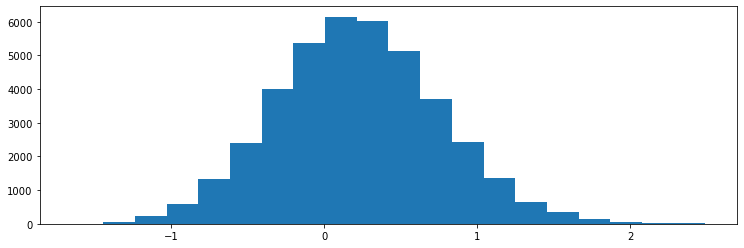

In [17]:
fig, ax = plt.subplots(figsize = (12.5,4))

ax.hist(trace['alpha'],bins = 20)
print(trace['alpha'].shape)
plt.show()

In [18]:
import numpy as np
def score_model(theta_0, s_max, alpha, OS, DS):
    return theta_0 + (s_max - theta_0)/(1+np.exp(-(alpha+OS-DS)))

In [19]:
def sample_outcome(team1, team2):
    id1 = ref[team1]
    id2 = ref[team2]
    
    o1_sample = trace['OS'][:,id1][10000:]
    o2_sample = trace['OS'][:,id2][10000:]
    
    d1_sample = trace['DS'][:,id1][10000:]
    d2_sample = trace['DS'][:,id2][10000:]
    
    theta_0_sample = trace['theta_0'][10000:]
    alpha_sample = trace['alpha'][10000:]
    s_max_sample = trace['smax'][10000:]
    
    sample_scores_1 = score_model(theta_0_sample, s_max_sample, alpha_sample, o1_sample, d2_sample)
    sample_scores_2 = score_model(theta_0_sample, s_max_sample, alpha_sample, o2_sample, d1_sample)
    
    fig, ax = plt.subplots(1,2,figsize = (12.5,4))

    ax[0].hist(sample_scores_1,bins = 20, alpha = 0.5, label = team1)
    ax[0].hist(sample_scores_2,bins = 20, alpha = 0.5, label = team2)
    
    actual_score_1 = df_in.query(f'Offense == {id1} & Defense == {id2}')['Score'].values
    ax[0].axvline(actual_score_1, linestyle = '--', color = 'blue', label = team1)
    
    actual_score_2 = df_in.query(f'Offense == {id2} & Defense == {id1}')['Score'].values
    ax[0].axvline(actual_score_2, linestyle = '--', color = 'k', label = team2)
    
    ax[0].legend()
    
    diff = sample_scores_1 - sample_scores_2
    ax[1].hist(diff, bins = 20, alpha = 0.7, label = 'Score Difference')
    
    actual_score_diff = actual_score_1 - actual_score_2
    ax[1].axvline(actual_score_diff, linestyle = '--', color = 'k')
    ax[1].set_title('Score Difference')

    plt.show()

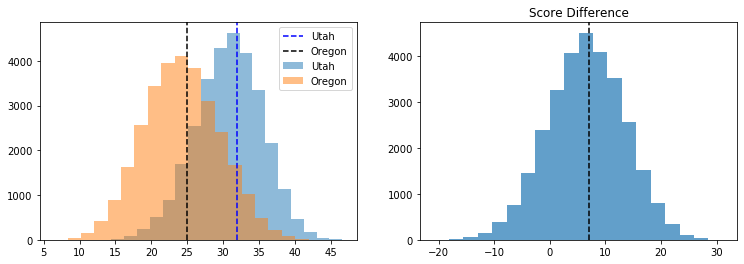

In [20]:
sample_outcome("Utah", "Oregon")

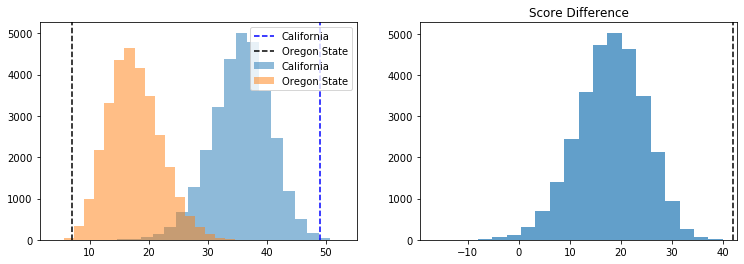

In [21]:
sample_outcome('California','Oregon State')

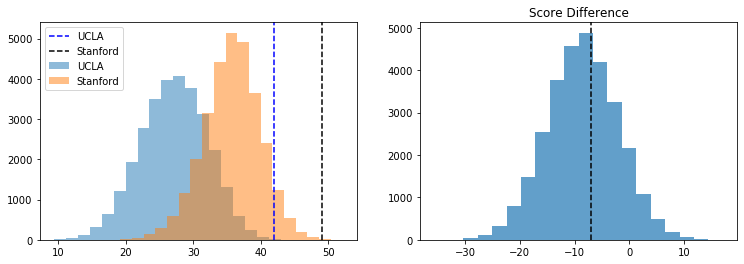

In [22]:
sample_outcome('UCLA','Stanford')